In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import os
from statistics import mean
import notebook_functions

In [2]:
def calculate_ellipse_from_mask(binary_mask):
    mask = binary_mask.astype(np.int32)
    y_indices, x_indices = np.indices(mask.shape)
    positive_pixels = mask == 255
    result_x = x_indices[positive_pixels]
    result_y = y_indices[positive_pixels]
    n = len(result_x)

    sx = np.sum(result_x)
    cx = sx / len(result_x)
    sxx = np.sum(np.square(result_x))

    sy = np.sum(result_y)
    cy = sy / len(result_y)
    syy = np.sum(np.square(result_y))

    mult_list = [x * y for x, y in zip(result_x, result_y)]
    sxy = np.sum(mult_list)

    sigma_x2 = (sxx / n) - cx ** 2
    sigma_y2 = (syy / n) - cy ** 2
    sigma_xy = (sxy / n) - (cx * cy)

    cov_matrix = [[sigma_x2, sigma_xy], [sigma_xy, sigma_y2]]
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    direction_a = eigenvectors[0] / np.linalg.norm(eigenvectors[0])
    direction_b = eigenvectors[1] / np.linalg.norm(eigenvectors[1])

    a = int(2 * (math.sqrt(abs(eigenvalues[0]))))  # semi major axis of projected ellipse
    b = int(2 * (math.sqrt(abs(eigenvalues[1]))))  # semi minor axis of projected ellipse

    return [a, b], [int(cx), int(cy)], [direction_a, direction_b] ,[*eigenvectors],


In [3]:
def draw_axes(img, img_ellipse):
    axes, center, direction, _ = img_ellipse
    a, b = axes
    direction_a, direction_b = direction

    print(a, b, center, direction_a, direction_b)

    end_point_a = (int(center[0] + a * direction_a[0]), int(center[1] + a * direction_a[1]))
    end_point_b = (int(center[0] + b * direction_b[0]), int(center[1] + b * direction_b[1]))

    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    font_scale = 1
    font_color = (255, 0, 0)  # Red color in BGR format
    thickness = 2

    major_letter = (
        int((center[0] + a * direction_a[0])),
        int((center[1] + a * direction_a[1]))
    )
    minor_letter = (
        int((center[0] + b * direction_b[0])),
        int((center[1] + b * direction_b[1]))
    )

    cv2.line(img, center, end_point_a, (0, 255, 0), 2)
    cv2.line(img, center, end_point_b, (0, 255, 0), 2)
    cv2.putText(img, "a", major_letter, font, font_scale, font_color, thickness, cv2.LINE_AA)
    cv2.putText(img, "b", minor_letter, font, font_scale, font_color, thickness, cv2.LINE_AA)


In [4]:
# CALCULATE THE NEXT ANGLE IF NEEDED
def angle_estimation(index_view):
    if oblate_angles[index_view] != -1: return oblate_angles[index_view]   # Return if already calculated in another cycle

    #Spheroid values
    A, B = oblate_spheroid
    b_curr = axe_b_all_views[index_view]
    fruit_rot = 'downwards'

    curr_cos_theta = math.sqrt(abs((pow(b_curr, 2) - pow(B, 2))/(pow(A, 2) - pow(B, 2))))

    curr_theta_pos = np.degrees(np.arccos(curr_cos_theta))
    curr_theta_neg = np.degrees(-np.arccos(curr_cos_theta))
    current_view_angles = (curr_theta_pos, curr_theta_neg)

    rotation_per_view = 360 / len(axe_b_all_views) - 5
    correct_theta = lambda ascending_sequence: current_view_angles[0] if ascending_sequence and (fruit_rot == 'downwards') or (not ascending_sequence) and (fruit_rot == 'upwards') else current_view_angles[1]

    # Second ambiguity
    if 0 <= abs(current_view_angles[0]) <= rotation_per_view or abs(90 - rotation_per_view) <= abs(current_view_angles[0]) >= 0:   # Value calculated is in range or a local extrema
        if index_view < len(image_files) - 1:
            temp_correct_theta_value = correct_theta(get_trend_for_view(index_view, 0))
            oblate_angles[index_view] = temp_correct_theta_value
            next_view_angle = angle_estimation(index_view + 1)
            if next_view_angle in [0.0, 90.0, -90.0] or oblate_angles[index_view - 1] in [0.0, 90.0, -90.0]:
                theta = correct_theta(get_trend_for_view(index_view, 0))
            else:
                theta = choose_smooth_angle(oblate_angles[index_view - 1])
        else:
            theta = correct_theta(get_trend_for_view(index_view, 0))
    else:
        theta = correct_theta(get_trend_for_view(index_view, 0))

    oblate_angles[index_view] = theta
    return theta

In [5]:
def get_trend_for_view(index_view, direction = 0, step = 0):
    b_axes = prev_post_values_b(index_view, axe_b_all_views, step, direction)  # Try first with direction 0, in other recursions does direction 1 - forward
    trend = estimate_b_axe_trend(b_axes)
    if trend is None:
        return get_trend_for_view(index_view, 1, step + 1)
    else:
        return trend


In [6]:
def estimate_b_axe_trend(b_axes):
    mean_seq = mean(b_axes)
    if b_axes[0] < mean_seq < b_axes[-1]:
        return True   # "Ascending"
    elif b_axes[0] > mean_seq > b_axes[-1]:
        return False  # "Descending"
    else:
        return None   # No clear trend

In [7]:
def prev_post_values_b(current_b_index, b_list, steps, direction = 0):
    enlarged_b_list = [*b_list, *b_list]
    enlarged_index = current_b_index + len(b_list) - 1 if current_b_index < (len(b_list) / 2) else current_b_index
    total_steps = 3 + steps

    if direction < 0:
        b_axes = enlarged_b_list[(enlarged_index - total_steps) : index]
    elif direction > 0:
        b_axes = enlarged_b_list[enlarged_index : (enlarged_index + total_steps)]
    else:
        b_axes = enlarged_b_list[enlarged_index - 2 : enlarged_index + 2]
    return b_axes

In [8]:
def choose_smooth_angle(calc_angle):
    diff_0 = abs(calc_angle - 0)
    diff_90 = abs(calc_angle - 90)
    diff_minus_90 = abs(calc_angle + 90)

    if diff_0 < diff_90 and diff_0 < diff_minus_90 and diff_0 < 40:  # Lower than 40 degrees of difference
        return 0
    elif diff_90 < diff_0 and diff_90 < diff_minus_90:
        return 90
    else:
        return -90

In [9]:
def join_images(images):
    min_height = min([image.shape[0] for image in images])
    resized_imgs = [cv2.resize(image, (image.shape[1], min_height)) for image in images]
    joined_imgs = cv2.hconcat(resized_imgs)
    return joined_imgs

In [10]:
def write_angle_on_img(img_to_draw, angle_text, color = (255, 0, 0)):
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (50, 50)
    fontScale = 0.5
    thickness = 2

    cv2.putText(img_to_draw, str(angle_text), org, font, fontScale, color, thickness, cv2.LINE_AA)
    return img_to_draw

In [11]:
def calculate_z_coordinates(img, index_view, z_coordinates):
    _, center, _, eigenvectors = projected_ellipses[index_view]

    p11 = eigenvectors[1][0]*np.sin(oblate_angles[index_view])
    p12 = eigenvectors[1][0]*np.sin(oblate_angles[index_view])
    p13 = np.cos(oblate_angles[index_view])

    p1 = [p11, p12, p13]
    p2 = [eigenvectors[0][0], eigenvectors[0][1], 0.0]
    p3 = np.cross(p1, p2)

    pose_matrix = np.array([p1, p2, p3])
    equation_matrix = [[1/(B**2), 0, 0], [0, 1/(A**2), 0], [0, 0, 1/(A**2)]]
    matrix_A = pose_matrix.T * equation_matrix * pose_matrix

    for y_pos in range(img.shape[0]):
        for x_pos in range(img.shape[1]):
            xp = x_pos - center[0]
            yp = y_pos - center[1]
            xpyp = [xp, yp]

            # Calculate C
            matrixA1 = np.delete(matrix_A, 2, 1)
            matrixA1 = np.delete(matrixA1, 2, 0)
            C_0 = np.dot(xpyp, matrixA1)
            c = np.dot(C_0, np.transpose(xpyp)) - 1

            # Calculate B
            matrixA2 = np.delete(matrix_A, 0, 1)
            matrixA2 = np.delete(matrixA2, 0, 1)
            matrixA2 = np.delete(matrixA2, 2, 0)
            matrixA3 = np.delete(matrix_A, 0, 0)
            matrixA3 = np.delete(matrixA3, 0, 0)
            matrixA3 = np.delete(matrixA3, 2, 1)
            b = np.dot(xpyp, matrixA2) + np.dot(matrixA3, np.transpose(xpyp))
            b = b[0]

            # Calculate A
            a = matrix_A[2][2]

            # Calculate Z
            sqrt = b*b-4*a*c
            z = (-b + math.sqrt(sqrt))/(2*a)
            z_coordinates[y_pos][x_pos] = z

In [12]:
fruit_folder = "../data/tomatoes/obj0001/"
axe_b_all_views = []
axe_a_all_views = []
projected_ellipses = []
oblate_spheroid = []
image_files = sorted([file for file in os.listdir(fruit_folder)])
z_coordinates_views_all = []
oblate_angles = [-1 for element in range(len(image_files))]

In [13]:
for image_name in image_files:
    file_path = os.path.join(fruit_folder, image_name)
    img = cv2.imread(file_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY)
    ellipse = calculate_ellipse_from_mask(mask)
    axes_length, _, _, _ = ellipse
    minor_axis_length, major_axis_length = axes_length
    axe_b_all_views.append(minor_axis_length)
    axe_a_all_views.append(major_axis_length)
    projected_ellipses.append(ellipse)

In [14]:
# SPHEROID CALCULATION
A = mean(axe_a_all_views)
B = min(axe_b_all_views)
oblate_spheroid = [A, B]

In [15]:
for index, image_name in enumerate(image_files):
    file_path = os.path.join(fruit_folder, image_name)
    img = cv2.imread(file_path)
    img_axes = cv2.imread(file_path)
    oblate_angle = angle_estimation(index) # A, B, b_i, b_axes[i-1, i, i+1]

# Find z coordinates for pixels
* For one image

In [16]:
img = cv2.imread(fruit_folder +"im02.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
current_img = 2 # The img to calculate the z pixels for img 0
z_coordinates = np.zeros_like(img)
print(z_coordinates.shape)

(331, 361)


In [17]:
_, center, _, eigenvectors = projected_ellipses[current_img]

p11 = eigenvectors[1][0]*np.sin(oblate_angles[current_img])
p12 = eigenvectors[1][0]*np.sin(oblate_angles[current_img])
p13 = np.cos(oblate_angles[current_img])

p1 = [p11, p12, p13]
p2 = [eigenvectors[0][0], eigenvectors[0][1], 0.0]
p3 = np.cross(p1, p2)

pose_matrix = np.array([p1, p2, p3])
equation_matrix = [[1/(B**2), 0, 0], [0, 1/(A**2), 0], [0, 0, 1/(A**2)]]
matrix_A = pose_matrix.T * equation_matrix * pose_matrix

In [18]:
for y_pos in range(img.shape[0]):
    for x_pos in range(img.shape[1]):
        xp = x_pos - center[0]
        yp = y_pos - center[1]
        xpyp = [xp, yp]

        # Calculate C
        matrixA1 = np.delete(matrix_A, 2, 1)
        matrixA1 = np.delete(matrixA1, 2, 0)
        C_0 = np.dot(xpyp, matrixA1)
        c = np.dot(C_0, np.transpose(xpyp)) - 1

        # Calculate B
        matrixA2 = np.delete(matrix_A, 0, 1)
        matrixA2 = np.delete(matrixA2, 0, 1)
        matrixA2 = np.delete(matrixA2, 2, 0)
        matrixA3 = np.delete(matrix_A, 0, 0)
        matrixA3 = np.delete(matrixA3, 0, 0)
        matrixA3 = np.delete(matrixA3, 2, 1)
        b = np.dot(xpyp, matrixA2) + np.dot(matrixA3, np.transpose(xpyp))
        b = b[0]

        # Calculate A
        a = matrix_A[2][2]

        # Calculate Z
        sqrt = b*b-4*a*c
        z = (-b + math.sqrt(sqrt))/(2*a)
        z_coordinates[y_pos][x_pos] = z

Text(0.5, 0, 'Z Value')

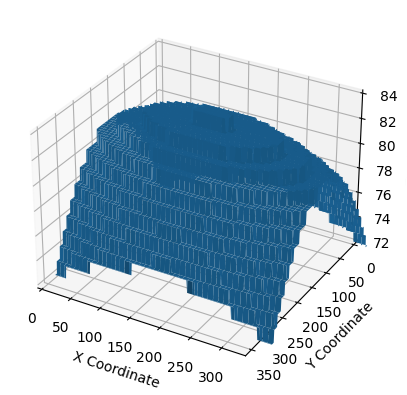

In [19]:
# Create X and Y coordinates
y = np.arange(0, img.shape[0])
x = np.arange(0, img.shape[1])
X, Y = np.meshgrid(x, y)

# Create a 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([0, img.shape[0]]) # width
ax.set_ylim([img.shape[1], 0])

ax.plot_surface(X, Y, z_coordinates)

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Value')

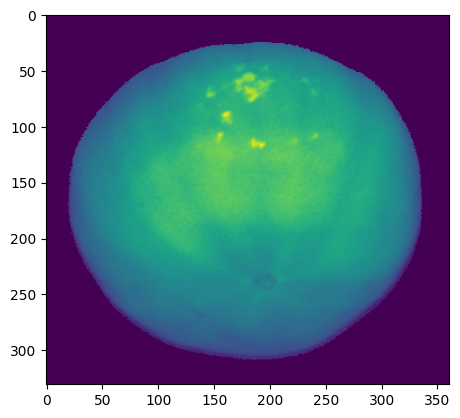

In [20]:
plt.imshow(img)

# Finding z coordinates for all images on folder


In [21]:
for index, image_name in enumerate(image_files):
    img = cv2.imread(fruit_folder + image_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    z_coordinates = np.zeros_like(img)
    calculate_z_coordinates(img, index, z_coordinates)
    z_coordinates_views_all.append(z_coordinates)

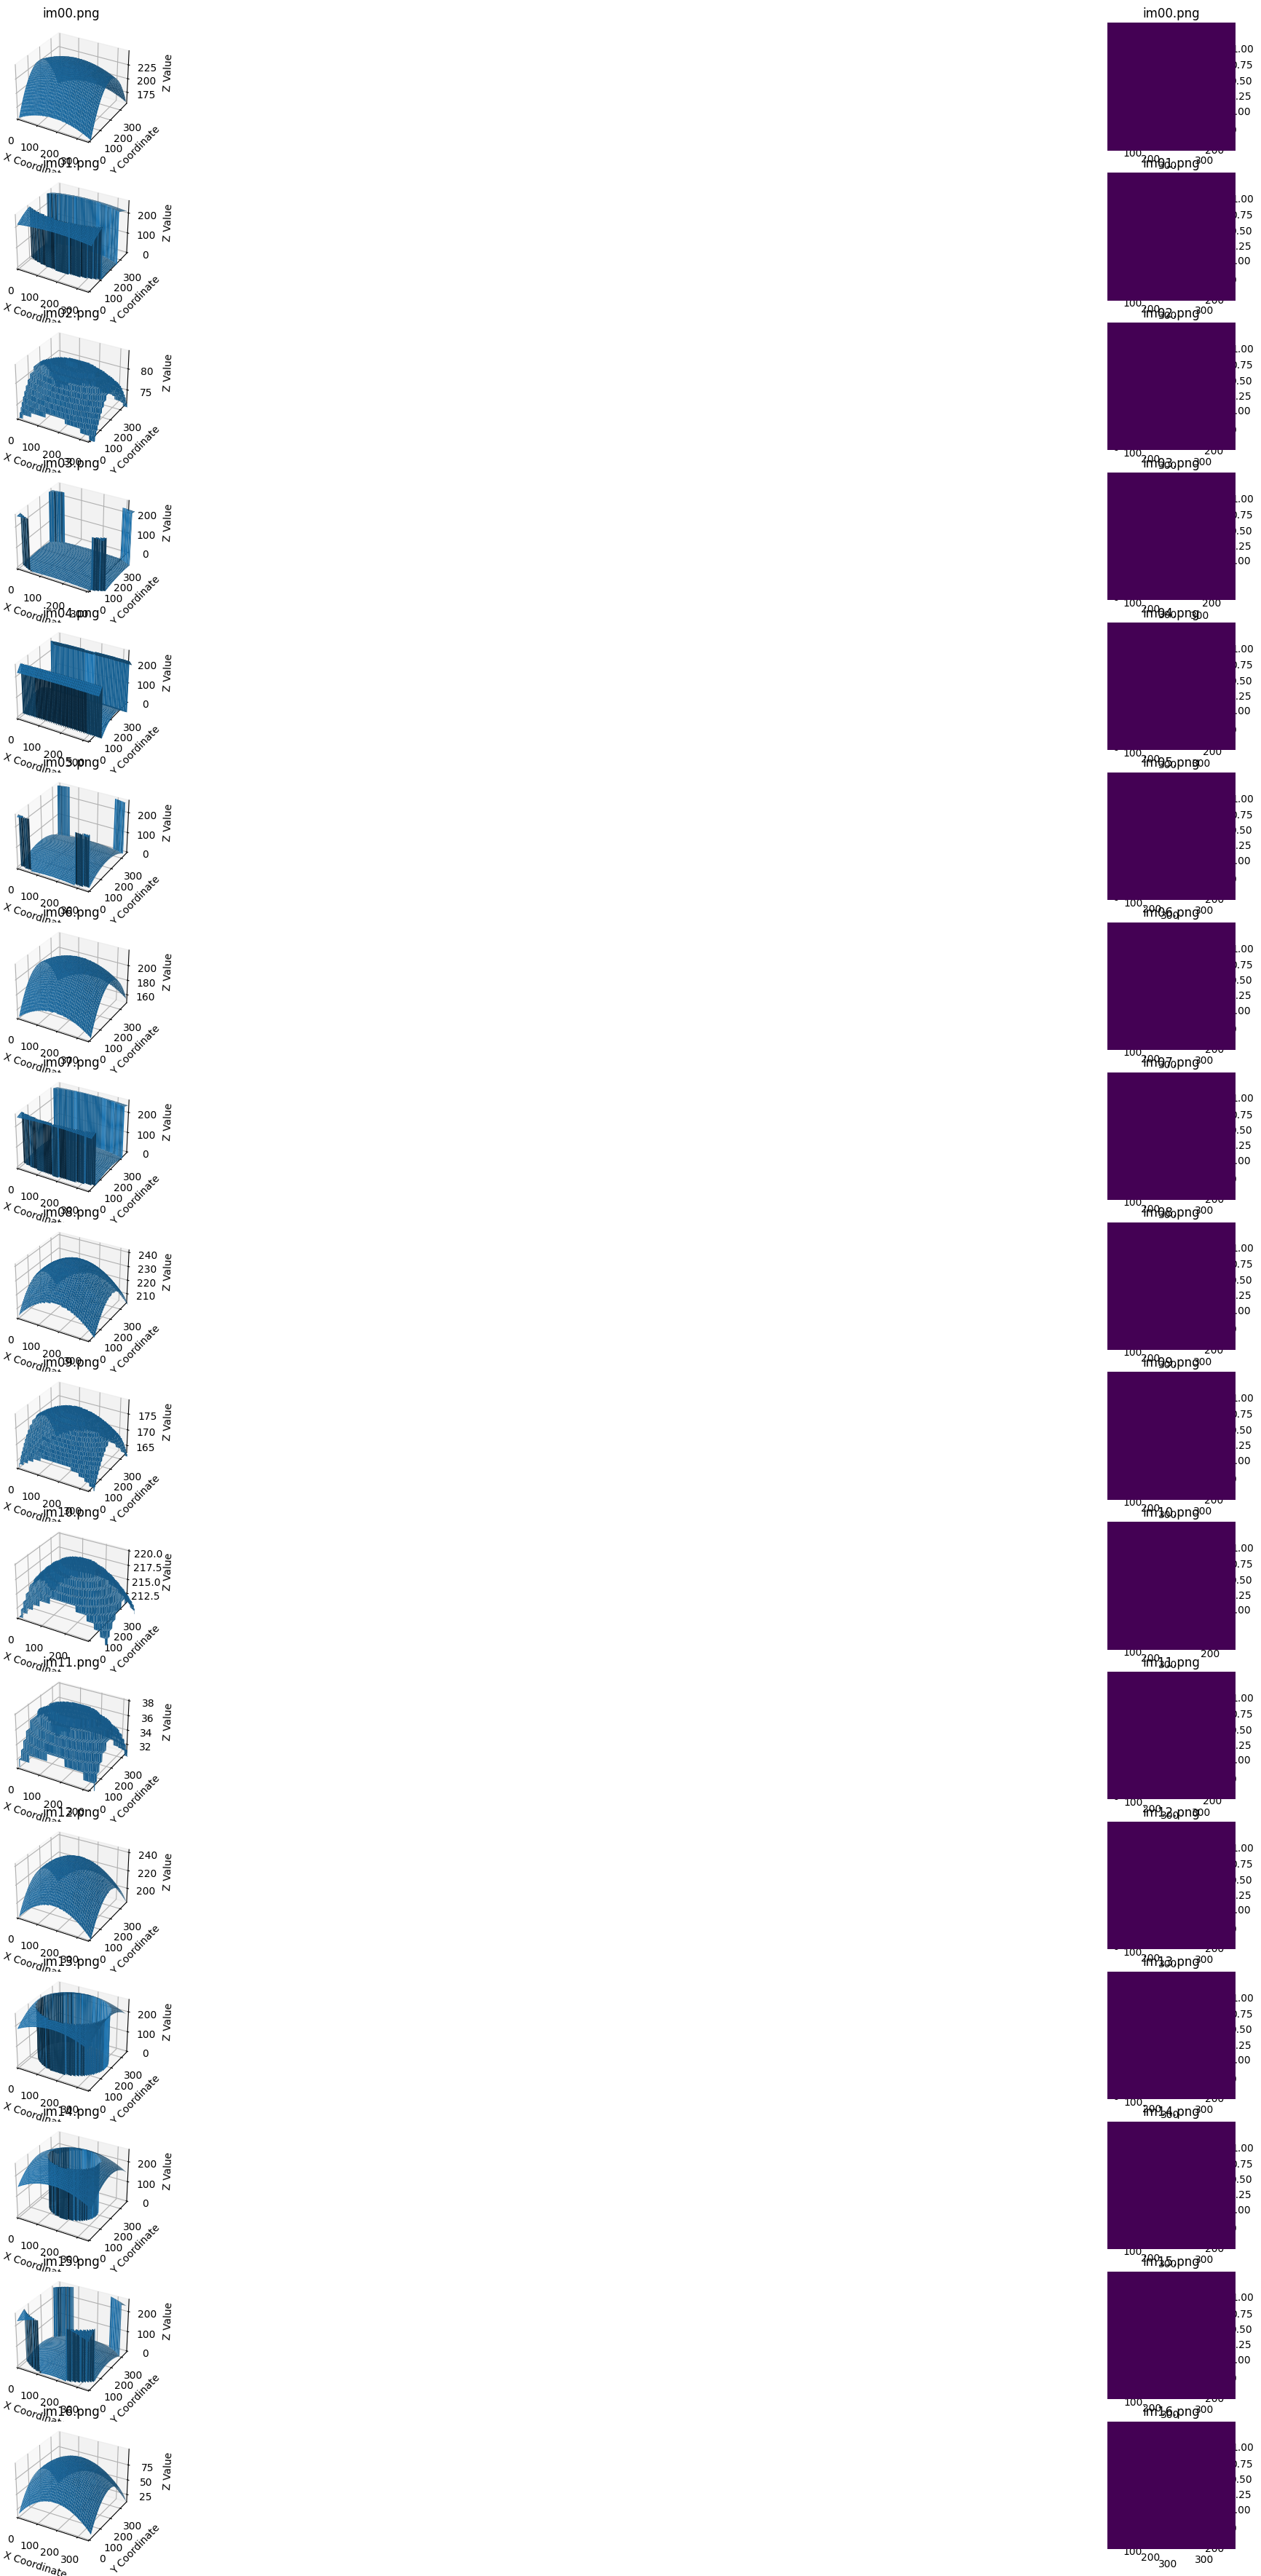

In [22]:
fig, axs = plt.subplots(len(image_files), 2, figsize=(30, 35), subplot_kw={'projection': '3d'}, constrained_layout=True)

for index, view in enumerate(image_files):
    img = cv2.imread(fruit_folder + view)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # img = img / 255
    z_coordinates = z_coordinates_views_all[index]

    # Create X and Y coordinates
    y = np.arange(0, img.shape[0])
    x = np.arange(0, img.shape[1])
    X, Y = np.meshgrid(x, y)

    # Create a 3D surface plot
    axs[index][0].set_xlim([0, img.shape[0]])    # width
    axs[index][0].set_ylim([0, img.shape[1]])
    axs[index][1].imshow(img)

    axs[index][0].plot_surface(X, Y, z_coordinates)
    axs[index][0].set_title(view)
    axs[index][1].set_title(view)

    axs[index][0].set_xlabel('X Coordinate')
    axs[index][0].set_ylabel('Y Coordinate')
    axs[index][0].set_zlabel('Z Value')

plt.show()